In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PowerLawNuisanceSpectralModel,
    PowerLawNormNuisanceSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    ExpCutoffPowerLawNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

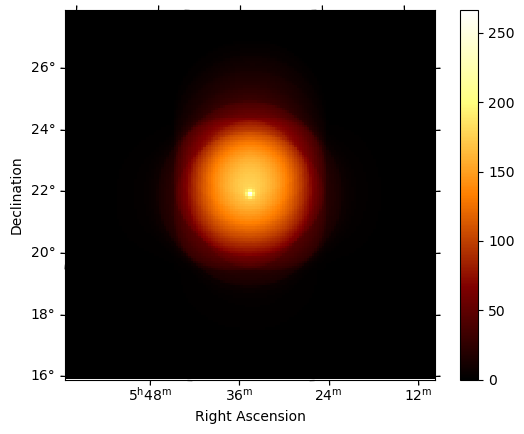

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1")

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Single Cases

In [4]:
factors = np.array([0.10])
sigma = 0.1
rnd = False
sys = sys_dataset(dataset_asimov, factors[0], rnd)
dataset_input = sys.create_dataset()


In [5]:
datasets_list = []
datasets_N_list = []
for i, factor in enumerate(factors):
    print(i, factor)
    sys = sys_dataset(dataset_asimov, factor, rnd)
    dataset = sys.create_dataset()
    datasets = Datasets(dataset)
    datasets_list.append(dataset)
    
    dataset_N = sys.create_dataset_N()
    
    sigma_a = sigma
    sigma_i = sigma #??unclear
    sigma_l = sigma #??unclear

    penalising_covmatrix = [[1/sigma_a**2, 0, 0], [0, 1/sigma_i**2, 0], [0, 0, 1/sigma_l**2]] #form of matrix unclear

    penalising_invcovmatrix =  penalising_covmatrix
    dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
    datasets_N = Datasets(dataset_N)
    datasets_N_list.append(dataset_N)

0 0.1


In [6]:
%%time
fits = []
for i, factor in enumerate(factors):
    print(i, factor)
    fit = Fit(store_trace=False)
    result = fit.run(datasets)
    fits.append(fit)

0 0.1
CPU times: total: 7.84 s
Wall time: 7.85 s


In [7]:
%%time
fits_N = []
for i, factor in enumerate(factors):
    fit_N = Fit(store_trace=False)
    result_N = fit_N.run(datasets_N)
    fits_N.append(fit_N)

CPU times: total: 6.62 s
Wall time: 6.62 s


## Correlation

In [8]:
from gammapy.modeling.fit import Registry
registry= Registry()

def covariance_ (fit_compute, datasets_compute):
    #parameters = Parameters.from_stack([datasets_compute.models.parameters])
    parameters = datasets_compute.models.parameters
    parameters = parameters.free_parameters

    kwargs = fit_compute.covariance_opts.copy()
    kwargs["minuit"] = fit_compute.minuit
    backend = kwargs.pop("backend", fit_compute.backend)
    compute = registry.get("covariance", backend)

    with parameters.restore_status():
        if fit_compute.backend == "minuit":
            method = "hesse"
        else:
            method = ""
        factor_matrix, info = compute(
            parameters=parameters, function=datasets_compute.stat_sum, **kwargs
        )
        covariance = Covariance.from_factor_matrix(
            parameters=parameters, matrix=factor_matrix
        )

        #covariance = covariance.get_subcovariance(datasets_compute.models.parameters)
    return covariance

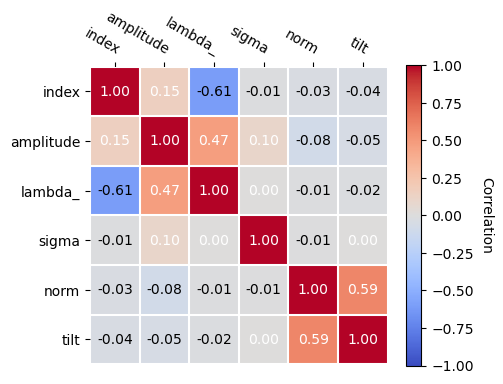

In [9]:
covariance  = covariance_(fit, dataset)
covariance.plot_correlation()

#for i, factor in enumerate(factors):
 #   print('factor', i+1, '=', factor)
  #  covariance  = covariance_(fits[i], datasets_list[i])
   # covariance.plot_correlation()


fig = plt.gcf()
fig.savefig("plots/3_corr_matrix_standard.png")

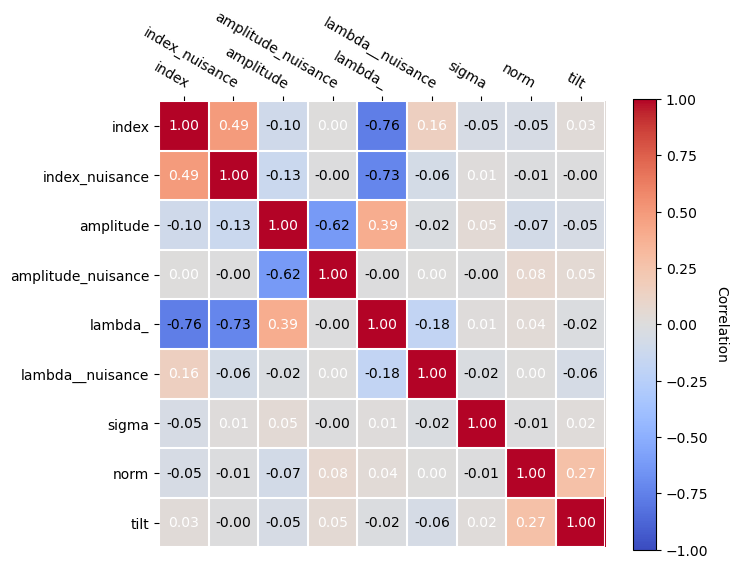

In [10]:
covariance_N  = covariance_(fit_N, dataset_N)
covariance_N.plot_correlation()

#for i, factor in enumerate(factors):
 #   print('factor', i+1, '=', factor)
  #  covariance_N  = covariance_(fits_N[i], datasets_N_list[i])
   # covariance_N.plot_correlation()


fig = plt.gcf()
fig.savefig("plots/3_corr_matrix_nuisance.png")

In [11]:
print(fits_N,'\n', fits)